#  Modulo 2 – Single Neuron & Perceptron from scratch

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(42)           # -- reproducibilidad
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


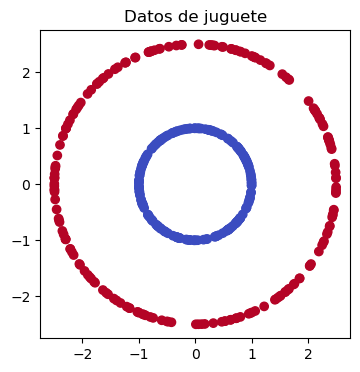

In [12]:
# 1. Datos sintéticos (clasificación binaria no lineal)
N = 200       # puntos por clase
D = 2         # dim. entrada
K = 2         # clases
X = torch.zeros(N*K, D, device=device)
y = torch.zeros(N*K, 1, device=device)

for j, r in enumerate([1.0, 2.5]):           # 2 “círculos” concéntricos
    ix = range(N*j, N*(j+1))
    theta = torch.linspace(0, 2*torch.pi, N) + 0.2*torch.randn(N)
    X[ix] = torch.stack((r*torch.sin(theta), r*torch.cos(theta)), dim=1)
    y[ix] = j                                   # etiqueta 0 o 1

plt.figure(figsize=(4,4))
plt.scatter(X[:,0].cpu(), X[:,1].cpu(), c=y.cpu().squeeze(), cmap='coolwarm')
plt.title("Datos de juguete"); plt.show()

In [13]:
# 2. NEURONA LOGÍSTICA — entrenamiento *a mano* (gradientes explícitos)
#---------------------------------------------------------------------
# Modelo: p = σ(wx + b)  →  y_hat = round(p)
# Loss  : Binary Cross-Entropy

# parámetros “crudos”
w = torch.randn(D, 1, device=device, requires_grad=False) * 0.1
b = torch.zeros(1, device=device, requires_grad=False)
lr = 1e-1
steps = 5_000

loss_history = []
for t in range(steps):
    # forward
    logits = X.mm(w) + b                # shape (N*K, 1)
    probs  = torch.sigmoid(logits)
    loss   = -(y*torch.log(probs) + (1-y)*torch.log(1-probs)).mean()

    # backward (derivadas analíticas)
    grad_logits = probs - y                     # dL/dlogits
    grad_w = X.t().mm(grad_logits) / len(X)     # dL/dw
    grad_b = grad_logits.mean()                 # dL/db

    # update
    w -= lr * grad_w
    b -= lr * grad_b

    if t % 500 == 0:
        loss_history.append(loss.item())

print("Loss final (manual):", loss.item())


Loss final (manual): 0.6931228637695312


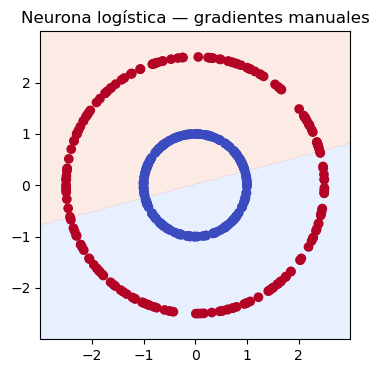

In [14]:
#------------- visualización de la frontera -------------------------
def plot_decision_boundary(w, b, title):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 200),
                            torch.linspace(y_min, y_max, 200),
                            indexing='ij')
    grid = torch.cat([xx.reshape(-1,1), yy.reshape(-1,1)], dim=1).to(device)
    with torch.no_grad():
        zz = torch.sigmoid(grid.mm(w) + b).reshape(xx.shape)
    plt.figure(figsize=(4,4))
    plt.contourf(xx.cpu(), yy.cpu(), (zz>0.5).cpu(), alpha=.2, cmap='coolwarm')
    plt.scatter(X[:,0].cpu(), X[:,1].cpu(), c=y.cpu().squeeze(), cmap='coolwarm')
    plt.title(title); plt.show()

plot_decision_boundary(w, b, "Neurona logística — gradientes manuales")

Loss final (autograd): 0.6931228637695312


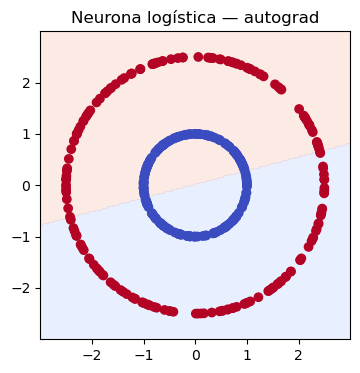

In [15]:
# 3. NEURONA LOGÍSTICA — ahora sí con autograd 
# --------------------------------------------------------
w2 = torch.randn(D, 1, device=device)          # ← hoja
w2.mul_(0.1)                                   # escala IN-PLACE, sigue siendo hoja
w2.requires_grad_()                            # activa gradientes

b2 = torch.zeros(1, device=device, requires_grad=True)  # ya es hoja

optim = torch.optim.SGD([w2, b2], lr=lr)

for t in range(steps):
    logits = X.mm(w2) + b2
    loss = F.binary_cross_entropy_with_logits(logits, y)
    optim.zero_grad()
    loss.backward()
    optim.step()

print("Loss final (autograd):", loss.item())
plot_decision_boundary(w2.detach(), b2.detach(),
                       "Neurona logística — autograd")

In [16]:

# 4. PERCEPTRÓN LINEAL MULTICAPA (2→4→1) SIN nn.Module — 

H = 4                              # neuronas ocultas

# --- pesos y sesgos como parámetros-hoja ----------------------------
W1 = torch.randn(D, H, device=device)           # hoja
W1.mul_(0.1)                                    # escala IN-PLACE ⇒ sigue siendo hoja
W1.requires_grad_()                             # activa gradientes

b1 = torch.zeros(H, device=device, requires_grad=True)

W2 = torch.randn(H, 1, device=device)           # hoja
W2.mul_(0.1)
W2.requires_grad_()

b2 = torch.zeros(1, device=device, requires_grad=True)

optim2 = torch.optim.Adam([W1, b1, W2, b2], lr=2e-2)

epochs = 3_000
for epoch in range(epochs):
    # forward
    h = torch.tanh(X @ W1 + b1)     # capa oculta
    logits = h @ W2 + b2            # salida
    loss = F.binary_cross_entropy_with_logits(logits, y)

    # backward + update
    optim2.zero_grad()
    loss.backward()
    optim2.step()

    if epoch % 500 == 0:
        print(f"epoch {epoch:4d} | loss {loss.item():.4f}")

print("Perceptrón (sin nn.Module) — loss final:", loss.item())



epoch    0 | loss 0.6933
epoch  500 | loss 0.0294
epoch 1000 | loss 0.0096
epoch 1500 | loss 0.0048
epoch 2000 | loss 0.0028
epoch 2500 | loss 0.0018
Perceptrón (sin nn.Module) — loss final: 0.0012462548911571503


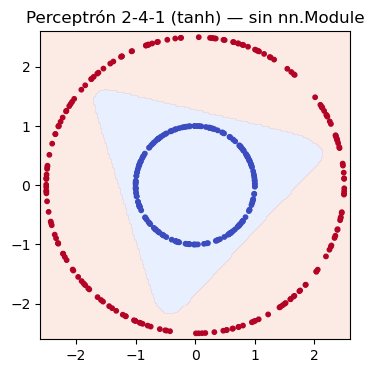

In [17]:
def plot_decision_boundary_full(W1, b1, W2, b2, title):
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 200),
                            torch.linspace(y_min, y_max, 200),
                            indexing='ij')
    grid = torch.cat([xx.reshape(-1,1), yy.reshape(-1,1)], dim=1).to(device)

    with torch.no_grad():
        h = torch.tanh(grid @ W1 + b1)
        logits = h @ W2 + b2
        probs = torch.sigmoid(logits).reshape(xx.shape)

    plt.figure(figsize=(4,4))
    plt.contourf(xx.cpu(), yy.cpu(), (probs>0.5).cpu(), alpha=0.2, cmap='coolwarm')
    plt.scatter(X[:,0].cpu(), X[:,1].cpu(), c=y[:,0].cpu(), cmap='coolwarm', s=10)
    plt.title(title)
    plt.show()

plot_decision_boundary_full(W1.detach(), b1.detach(),
                            W2.detach(), b2.detach(),
                            "Perceptrón 2-4-1 (tanh) — sin nn.Module")


In [18]:
######################################################################
# 5. PERCEPTRÓN usando la API `nn.Module` — CORREGIDO / MEJORADO
######################################################################
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, in_dim=2, hid=4):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(hid, 1)

        # Inicializaciones recomendadas
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

model = SimpleMLP().to(device)
optim3 = torch.optim.AdamW(model.parameters(), lr=2e-2, weight_decay=1e-4) #OJO CON ESTA LÍNEA

epochs = 3_000
for epoch in range(epochs):
    logits = model(X)
    loss = F.binary_cross_entropy_with_logits(logits, y)
    optim3.zero_grad()
    loss.backward()
    optim3.step()

print("Perceptrón (nn.Module) — loss final:", loss.item())


KeyboardInterrupt: 

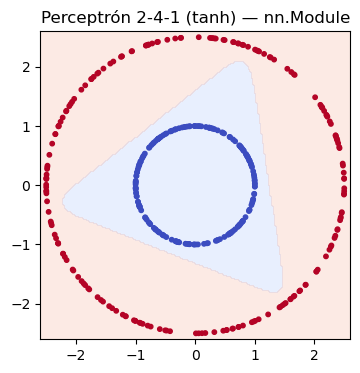

In [ ]:
def plot_decision_boundary_model(model, title):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 200),
                            torch.linspace(y_min, y_max, 200),
                            indexing='ij')
    grid = torch.cat([xx.reshape(-1,1), yy.reshape(-1,1)], dim=1).to(device)

    with torch.no_grad():
        logits = model(grid)
        probs = torch.sigmoid(logits).reshape(xx.shape)

    plt.figure(figsize=(4,4))
    plt.contourf(xx.cpu(), yy.cpu(), (probs > 0.5).cpu(), alpha=0.2, cmap='coolwarm')
    plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y[:, 0].cpu(), cmap='coolwarm', s=10)
    plt.title(title)
    plt.show()
plot_decision_boundary_model(model, "Perceptrón 2-4-1 (tanh) — nn.Module")


# Módulo nn.Module

## 1. Imports y dataset sintético multiclase

In [2]:
# 0. PREPARACIÓN (importaciones, dispositivo, datos)
######################################################################
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
# Dataset en espiral de 3 clases — bonito para visualizar fronteras
def make_spiral(n_per_class=300, k=3, noise=0.2):
    r = torch.linspace(0., 1., n_per_class)
    X, y = [], []
    for i in range(k):
        t = r*4*np.pi + (i*2*np.pi/k)               # giro
        xi = torch.stack([r*torch.sin(t), r*torch.cos(t)], dim=1)
        xi += noise*torch.randn_like(xi)
        X.append(xi);  y.append(torch.full((n_per_class,), i))
    return torch.cat(X), torch.cat(y)

X, y = make_spiral()
X_train, y_train = X.to(device), y.to(device)

ds      = TensorDataset(X_train, y_train)
loader  = DataLoader(ds, batch_size=128, shuffle=True)

num_feats = X.shape[1]   # =2
num_classes = len(torch.unique(y))   # =3


In [3]:
######################################################################
# OPCIÓN B — “Pinwheel” (4 brazos en espiral, 4 clases)
######################################################################
def make_pinwheel(n_per_class=300, k=4, radial_std=0.3, tangential_std=0.05):
    """
    Dataset clásico para GANs: k brazos rotados en espiral.
    """
    r = torch.randn(n_per_class * k, 1) * radial_std + 1.5          # radio
    θ = torch.arange(k).repeat_interleave(n_per_class).float()      # brazo base
    θ = θ / k * 2 * np.pi + torch.randn_like(r) * tangential_std    # giro + ruido

    X = torch.cat([r * torch.sin(θ), r * torch.cos(θ)], dim=1)
    y = torch.arange(k).repeat_interleave(n_per_class)
    return X, y
X, y = make_pinwheel()

In [13]:
######################################################################
# OPCIÓN C — “Flor” de 3 pétalos (3 clases) – ideal para BatchNorm
######################################################################
def make_flower(n_per_class=350, petals=3, noise=0.07):
    """
    Cada clase ocupa un pétalo de una rosa polar r = 2 + 0.8 sin(petals·θ).
    """
    X, y = [], []
    for i in range(petals):
        θ = torch.rand(n_per_class) * 2 * np.pi
        r = 2 + 0.8 * torch.sin(petals * θ + i * 2 * np.pi / petals)
        xi = torch.stack([r * torch.cos(θ), r * torch.sin(θ)], dim=1)
        xi += noise * torch.randn_like(xi)
        X.append(xi)
        y.append(torch.full((n_per_class,), i))
    return torch.cat(X), torch.cat(y)
X, y = make_flower()

In [14]:
# Función auxiliar de entrenamiento (reutilizable en cada etapa)
######################################################################
def train(model, optim, epochs=200):
    model.train()
    for epoch in range(epochs):
        for xb, yb in loader:
            logits = model(xb)
            loss   = F.cross_entropy(logits, yb)
            optim.zero_grad()
            loss.backward()
            optim.step()
        if (epoch+1) % 50 == 0:
            acc = (model(X_train).argmax(1) == y_train).float().mean()
            print(f"Epoch {epoch+1:3d}/{epochs} – loss {loss:.4f} – acc {acc:.3f}")
    return model

In [15]:
# 1. MLP mínimo (sin activación) usando una clase nn.Module explícita
######################################################################
class MLPv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc   = nn.Linear(num_feats, num_classes)

    def forward(self, x):                       # logits → CrossEntropyLoss
        return self.fc(x)

model1 = MLPv1().to(device)
optim1 = torch.optim.SGD(model1.parameters(), lr=1e-1)

print("\n=== ETAPA 1 : MLP lineal ===")
train(model1, optim1)


=== ETAPA 1 : MLP lineal ===
Epoch  50/200 – loss 1.2528 – acc 0.384
Epoch 100/200 – loss 1.0655 – acc 0.391
Epoch 150/200 – loss 1.0658 – acc 0.388
Epoch 200/200 – loss 1.0989 – acc 0.387


MLPv1(
  (fc): Linear(in_features=2, out_features=3, bias=True)
)

In [16]:

# 2. Añadimos no linealidades y más capacidad
#    (ReLU + capa oculta) – seguimos con nn.Module explícito
######################################################################
class MLPv2(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.fc1  = nn.Linear(num_feats, hidden)
        self.act  = nn.ReLU()
        self.fc2  = nn.Linear(hidden, num_classes)

        # Buenas prácticas de inicialización
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity="relu")
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.fc2(x)

model2 = MLPv2().to(device)
optim2 = torch.optim.Adam(model2.parameters(), lr=3e-3)

print("\n=== ETAPA 2 : +ReLU, +capa oculta, optimizador Adam ===")
train(model2, optim2)


=== ETAPA 2 : +ReLU, +capa oculta, optimizador Adam ===
Epoch  50/200 – loss 1.3169 – acc 0.381
Epoch 100/200 – loss 1.1024 – acc 0.373
Epoch 150/200 – loss 1.2740 – acc 0.404
Epoch 200/200 – loss 1.0964 – acc 0.400


MLPv2(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

In [17]:
# 3. Misma arquitectura pero declarada con nn.Sequential
#    (demuestra la fluidez de ensamblar bloques)
######################################################################
def mlp_sequential(hidden=64, act=nn.Tanh()):
    return nn.Sequential(
        nn.Linear(num_feats, hidden),
        act,
        nn.Linear(hidden, num_classes)
    )

model3 = mlp_sequential(act=nn.LeakyReLU(0.1)).to(device)
optim3 = torch.optim.Adam(model3.parameters(), lr=3e-3)

print("\n=== ETAPA 3 : nn.Sequential + LeakyReLU ===")
train(model3, optim3)


=== ETAPA 3 : nn.Sequential + LeakyReLU ===
Epoch  50/200 – loss 1.0466 – acc 0.391
Epoch 100/200 – loss 1.0250 – acc 0.387
Epoch 150/200 – loss 1.0141 – acc 0.399
Epoch 200/200 – loss 1.0339 – acc 0.398


Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): LeakyReLU(negative_slope=0.1)
  (2): Linear(in_features=64, out_features=3, bias=True)
)

In [18]:
# 4. Regularización (Dropout) – mostramos versión con nn.ModuleList
######################################################################
class MLPv4(nn.Module):
    def __init__(self, hidden=[64, 32], p_drop=0.3):
        super().__init__()
        layers = []
        in_f = num_feats
        for h in hidden:
            layers += [nn.Linear(in_f, h), nn.GELU(), nn.Dropout(p_drop)]
            in_f   = h
        layers += [nn.Linear(in_f, num_classes)]
        self.net = nn.ModuleList(layers)        # permite inspección capa a capa

    def forward(self, x):
        for layer in self.net:
            x = layer(x)
        return x

model4 = MLPv4().to(device)
optim4 = torch.optim.Adam(model4.parameters(), lr=3e-3)

print("\n=== ETAPA 4 : +Dropout ===")
train(model4, optim4)


=== ETAPA 4 : +Dropout ===
Epoch  50/200 – loss 1.2340 – acc 0.382
Epoch 100/200 – loss 1.2166 – acc 0.386
Epoch 150/200 – loss 1.1955 – acc 0.399
Epoch 200/200 – loss 1.0274 – acc 0.366


MLPv4(
  (net): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [19]:
# 5. Weight Decay “bien hecho” → AdamW
######################################################################
model5 = MLPv4().to(device)                    # misma topología
optim5 = torch.optim.AdamW(model5.parameters(), lr=3e-3, weight_decay=1e-2)

print("\n=== ETAPA 5 : AdamW con weight decay ===")
train(model5, optim5)


=== ETAPA 5 : AdamW con weight decay ===
Epoch  50/200 – loss 1.0803 – acc 0.394
Epoch 100/200 – loss 0.6404 – acc 0.389
Epoch 150/200 – loss 0.7927 – acc 0.373
Epoch 200/200 – loss 0.9753 – acc 0.367


MLPv4(
  (net): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [20]:
# 6. Batch Normalization + activación separada + más jugueticos
######################################################################
class MLPv6(nn.Module):
    def __init__(self, hidden=[128, 64], p_drop=0.25):
        super().__init__()
        layers = []
        in_f = num_feats
        for h in hidden:
            layers += [
                nn.Linear(in_f, h),
                nn.BatchNorm1d(h),
                nn.GELU(),
                nn.Dropout(p_drop)
            ]
            in_f = h
        layers += [nn.Linear(in_f, num_classes)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model6 = MLPv6().to(device)
optim6 = torch.optim.RMSprop(model6.parameters(), lr=1e-3, momentum=0.9)

print("\n=== ETAPA 6 : +BatchNorm + GELU + RMSprop ===")
train(model6, optim6)


=== ETAPA 6 : +BatchNorm + GELU + RMSprop ===
Epoch  50/200 – loss 1.1920 – acc 0.409
Epoch 100/200 – loss 1.0502 – acc 0.411
Epoch 150/200 – loss 0.9420 – acc 0.401
Epoch 200/200 – loss 1.0540 – acc 0.396


MLPv6(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=64, out_features=3, bias=True)
  )
)

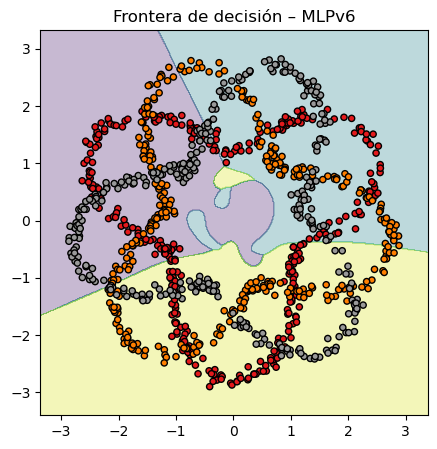

In [21]:

# 7. BONUS: visualiza la frontera de decisión final
######################################################################
def plot_decision_boundary(model, title=""):
    model.eval()
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 400),
                            torch.linspace(y_min, y_max, 400), indexing='ij')
    grid = torch.cat([xx.reshape(-1,1), yy.reshape(-1,1)], dim=1).to(device)
    with torch.no_grad():
        Z = model(grid).argmax(1).cpu().numpy()
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, alpha=.3)
    plt.scatter(X[:,0], X[:,1], c=y, cmap="Set1", edgecolor='k', s=20)
    plt.title(title); plt.axis('equal'); plt.show()

plot_decision_boundary(model6.cpu(), "Frontera de decisión – MLPv6")
